## Data Loading and Imports

In [2]:
%store -r __imp

In [3]:
__imp

The libraries have been loaded!


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from pathlib import Path
from pprint import pprint
from tqdm.auto import tqdm
import featuretools as ft
from joblib import dump,load

from sklearn.preprocessing import minmax_scale, StandardScaler
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV, RidgeClassifierCV, RidgeClassifier
from sklearn.metrics import make_scorer, log_loss
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.multioutput import MultiOutputClassifier
from  sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import SVC

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

RANDOM_SEED = 777
np.random.seed(RANDOM_SEED)
import warnings
warnings.filterwarnings(
    action='ignore',
)

In [2]:
metadata = pd.read_csv('data/metadata.csv')
train_labels = pd.read_csv('data/train_labels.csv', index_col="sample_id")
submission_format = pd.read_csv('data/submission_format.csv')

In [3]:
train_df = pd.read_csv('data/train_df.csv',index_col=0,header=[0,1])
train_df.sort_index(inplace=True,axis=1)
train_df.head()

m/z               0                                                 \
temp_bin  (-100, 0]  (0, 100] (100, 200] (1000, 1100] (1100, 1200]   
sample_id                                                            
S0000           0.0  0.004085   0.004641     0.000000          0.0   
S0001           0.0  0.000000   0.000000     0.000000          0.0   
S0002           0.0  0.002270   0.002495     0.000000          0.0   
S0003           0.0  0.001336   0.002464     0.000306          0.0   
S0004           0.0  0.005993   0.012429     0.000593          0.0   

m/z                                                                     ...  \
temp_bin  (1200, 1300] (1300, 1400] (1400, 1500] (200, 300] (300, 400]  ...   
sample_id                                                               ...   
S0000              0.0          0.0          0.0   0.001394   0.000188  ...   
S0001              0.0          0.0          0.0   0.000000   0.000000  ...   
S0002              0.0          0.0          0.0   0.001688   0.000636  ...   
S0003              0.0          0.0          0.0   0.001099   0.000992  ...   
S0004              0.0          0.0          0.0   0.009380   0.005099  ...   

m/z                 99                                                   \
temp_bin  (1300, 1400] (1400, 1500]    (200, 300] (300, 400] (400, 500]   
sample_id                                                                 
S0000              0.0          0.0  2.898509e-06   0.000003   0.000000   
S0001              0.0          0.0  0.000000e+00   0.000000   0.000000   
S0002              0.0          0.0  9.257968e-07   0.000001   0.000001   
S0003              0.0          0.0  4.379099e-06   0.000006   0.000005   
S0004              0.0          0.0  3.904920e-06   0.000004   0.000004   

m/z                                                                   
temp_bin  (500, 600]    (600, 700] (700, 800] (800, 900] (900, 1000]  
sample_id                                                             
S0000       0.000000  0.000000e+00   0.000000   0.000000    0.000000  
S0001       0.000000  0.000000e+00   0.000000   0.000000    0.000000  
S0002       0.000001  9.397170e-07   0.000001   0.000001    0.000001  
S0003       0.000005  4.693477e-06   0.000004   0.000004    0.000004  
S0004       0.000005  3.174421e-06   0.000004   0.000004    0.000003  

[5 rows x 1600 columns]

In [4]:
test_df = pd.read_csv('test_df.csv',index_col=0,header=[0,1])
test_df.sort_index(inplace=True,axis=1)
test_df.head()

m/z               0                                                 \
temp_bin  (-100, 0]  (0, 100] (100, 200] (1000, 1100] (1100, 1200]   
sample_id                                                            
S0766           0.0  0.410100   0.593334     0.206508     0.000000   
S0767           0.0  0.058563   0.073878     0.088571     0.097939   
S0768           0.0  0.029256   0.040753     0.013179     0.000000   
S0769           0.0  0.000261   0.000842     0.000000     0.000000   
S0770           0.0  0.003460   0.003929     0.000467     0.000000   

m/z                                                                     ...  \
temp_bin  (1200, 1300] (1300, 1400] (1400, 1500] (200, 300] (300, 400]  ...   
sample_id                                                               ...   
S0766         0.000000          0.0          0.0   0.606578   0.678006  ...   
S0767         0.063057          0.0          0.0   0.081069   0.083869  ...   
S0768         0.000000          0.0          0.0   0.037022   0.041347  ...   
S0769         0.000000          0.0          0.0   0.001313   0.001544  ...   
S0770         0.000000          0.0          0.0   0.003286   0.002893  ...   

m/z                 99                                                \
temp_bin  (1300, 1400] (1400, 1500] (200, 300] (300, 400] (400, 500]   
sample_id                                                              
S0766              0.0          0.0   0.001801   0.001626   0.001498   
S0767              0.0          0.0   0.000153   0.000187   0.000173   
S0768              0.0          0.0   0.000205   0.000122   0.000152   
S0769              0.0          0.0   0.000010   0.000010   0.000008   
S0770              0.0          0.0   0.000002   0.000002   0.000002   

m/z                                                                
temp_bin  (500, 600] (600, 700] (700, 800] (800, 900] (900, 1000]  
sample_id                                                          
S0766       0.001380   0.001495   0.001755   0.001762    0.001607  
S0767       0.000150   0.000183   0.000162   0.000146    0.000133  
S0768       0.000161   0.000158   0.000182   0.000248    0.000144  
S0769       0.000009   0.000012   0.000011   0.000012    0.000000  
S0770       0.000002   0.000001   0.000003   0.000002    0.000002  

[5 rows x 1600 columns]

In [5]:
train_files = metadata[metadata["split"] == "train"]["features_path"].to_dict()
val_files = metadata[metadata["split"] == "val"]["features_path"].to_dict()
test_files = metadata[metadata["split"] == "test"]["features_path"].to_dict()

print("Number of training samples: ", len(train_files))
print("Number of validation samples: ", len(val_files))
print("Number of testing samples: ", len(test_files))

Number of training samples:  766
Number of validation samples:  293
Number of testing samples:  511


In [6]:
all_test_files = val_files.copy()
all_test_files.update(test_files)
print("Total test files: ", len(all_test_files))

Total test files:  804


In [54]:
# Import submission format
submission_template_df = submission_format.copy(deep=True)

## Preprocessing

### train

In [7]:
def drop_frac_and_He(df):
    """
    Drops fractional m/z values, m/z values > 100, and carrier gas m/z

    Args:
        df: a dataframe representing a single sample, containing m/z values

    Returns:
        The dataframe without fractional an carrier gas m/z
    """

    # drop fractional m/z values
    df = df[df["m/z"].transform(round) == df["m/z"]]
    assert df["m/z"].apply(float.is_integer).all(), "not all m/z are integers"

    # drop m/z values greater than 99
    df = df[df["m/z"] < 100]

    # drop carrier gas
    df = df[df["m/z"] != 4]

    return df

In [8]:
def remove_background_abundance(df):
    """
    Subtracts minimum abundance value

    Args:
        df: dataframe with 'm/z' and 'abundance' columns

    Returns:
        dataframe with minimum abundance subtracted for all observations
    """

    df["abundance_minsub"] = df.groupby(["m/z"])["abundance"].transform(
        lambda x: (x - x.min())
    )

    return df

In [9]:
def scale_abun(df):
    """
    Scale abundance from 0-100 according to the min and max values across entire sample

    Args:
        df: dataframe containing abundances and m/z

    Returns:
        dataframe with additional column of scaled abundances
    """

    df["abun_minsub_scaled"] = minmax_scale(df["abundance_minsub"].astype(float))

    return df


In [10]:
# Preprocess function
def preprocess_sample(df):
    df = drop_frac_and_He(df)
    df = remove_background_abundance(df)
    df = scale_abun(df)
    return df

In [12]:
# Create a series of temperature bins
temprange = pd.interval_range(start=-100, end=1500, freq=100)
temprange

# Make dataframe with rows that are combinations of all temperature bins
# and all m/z values
allcombs = list(itertools.product(temprange, [*range(0, 100)]))

allcombs_df = pd.DataFrame(allcombs, columns=["temp_bin", "m/z"])
print(allcombs_df.shape)
allcombs_df.head()

(1600, 2)


,temp_bin,m/z
0,"(-100, 0]",0
1,"(-100, 0]",1
2,"(-100, 0]",2
3,"(-100, 0]",3
4,"(-100, 0]",4


In [80]:
type(allcombs_df.columns[1])

str

In [13]:
def abun_per_tempbin(df):

    """
    Transforms dataset to take the preprocessed max abundance for each
    temperature range for each m/z value

    Args:
        df: dataframe to transform

    Returns:
        transformed dataframe
    """

    # Bin temperatures
    df["temp_bin"] = pd.cut(df["temp"], bins=temprange)

    # Combine with a list of all temp bin-m/z value combinations
    df = pd.merge(allcombs_df, df, on=["temp_bin", "m/z"], how="left")

    # Aggregate to temperature bin level to find max
    df = df.groupby(["temp_bin", "m/z"]).max("abun_minsub_scaled").reset_index()

    # Fill in 0 for abundance values without information
    df = df.replace(np.nan, 0)

    # Reshape so each row is a single sample
    df = df.pivot_table(columns=["m/z", "temp_bin"], values=["abun_minsub_scaled"])

    return df

In [82]:
# Assembling preprocessed and transformed training set

train_features_dict = {}
print("Total number of train files: ", len(train_files))

for i, (sample_id, filepath) in enumerate(tqdm(train_files.items())):

    # Load training sample
    temp = pd.read_csv('data/' + filepath)

    # Preprocessing training sample
    train_sample_pp = preprocess_sample(temp)

    # Feature engineering
    train_sample_fe = abun_per_tempbin(train_sample_pp).reset_index(drop=True)
    train_features_dict[sample_id] = train_sample_fe

train_features = pd.concat(
    train_features_dict, names=["sample_id", "dummy_index"]
).reset_index(level="dummy_index", drop=True)

  0%|          | 0/766 [00:00<?, ?it/s]

Total number of train files:  766


100%|██████████| 766/766 [04:38<00:00,  2.75it/s]


### test

In [7]:
def drop_frac_and_He_test(df):
    """
    Drops fractional m/z values, m/z values > 100, and carrier gas m/z

    Args:
        df: a dataframe representing a single sample, containing m/z values

    Returns:
        The dataframe without fractional an carrier gas m/z
    """

    # drop fractional m/z values
    df = df[df["m/z"].transform(round) == df["m/z"]]
    assert df["m/z"].apply(float.is_integer).all(), "not all m/z are integers"

    # drop m/z values greater than 99
    df = df[df["m/z"] < 100]

    # drop carrier gas
    df = df[df["m/z"] != 4]

    return df

In [8]:
def remove_background_abundance_test(df):
    """
    Subtracts minimum abundance value

    Args:
        df: dataframe with 'm/z' and 'abundance' columns

    Returns:
        dataframe with minimum abundance subtracted for all observations
    """

    df["abundance_minsub"] = df.groupby(["m/z"])["abundance"].transform(
        lambda x: (x - x.min())
    )

    return df

In [9]:
def scale_abun_test(df):
    """
    Scale abundance from 0-100 according to the min and max values across entire sample

    Args:
        df: dataframe containing abundances and m/z

    Returns:
        dataframe with additional column of scaled abundances
    """

    df["abun_minsub_scaled"] = minmax_scale(df["abundance_minsub"].astype(float))

    return df

In [10]:
# Preprocess function
def preprocess_sample_test(df):
    df = drop_frac_and_He_test(df)
    df = remove_background_abundance_test(df)
    df = scale_abun_test(df)
    return df

In [17]:
# Create a series of temperature bins
temprange_test = pd.interval_range(start=-100, end=1500, freq=100)
temprange_test

# Make dataframe with rows that are combinations of all temperature bins
# and all m/z values
allcombs_test = list(itertools.product(temprange_test, [*range(0, 100)]))

allcombs_df_test = pd.DataFrame(allcombs_test, columns=["temp_bin", "m/z"])
print(allcombs_df_test.shape)
allcombs_df_test.head()

(1600, 2)


,temp_bin,m/z
0,"(-100, 0]",0
1,"(-100, 0]",1
2,"(-100, 0]",2
3,"(-100, 0]",3
4,"(-100, 0]",4


In [ ]:
# Create a series of temperature bins
temprange = pd.interval_range(start=-100, end=2000, freq=200)
temprange

# Make dataframe with rows that are combinations of all temperature bins
# and all m/z values
allcombs = list(itertools.product(temprange, [*range(0, 500)]))

allcombs_df = pd.DataFrame(allcombs, columns=["temp_bin", "m/z"])
display(allcombs_df.head())
print(allcombs_df.shape)

In [23]:

def abun_per_tempbin_test(df):

    """
    Transforms dataset to take the preprocessed max abundance for each
    temperature range for each m/z value

    Args:
        df: dataframe to transform

    Returns:
        transformed dataframe
    """

    # Bin temperatures
    df["temp_bin"] = pd.cut(df["temp"], bins=temprange_test)

    # Combine with a list of all temp bin-m/z value combinations
    df = pd.merge(allcombs_df_test, df, on=["temp_bin", "m/z"], how="left")

    # Aggregate to temperature bin level to find max
    df = df.groupby(["temp_bin", "m/z"]).max("abun_minsub_scaled").reset_index()

    # Fill in 0 for abundance values without information
    df = df.replace(np.nan, 0)

    # Reshape so each row is a single sample
    df = df.pivot_table(columns=["m/z", "temp_bin"], values=["abun_minsub_scaled"])

    return df

In [25]:
%%time
# Assembling preprocessed and transformed testing set

test_feat_dict = {}
print("Total number of test files: ", len(all_test_files))

for i, (sample_id, filepath) in enumerate(tqdm(all_test_files.items())):

    # Load testing sample
    temp = pd.read_csv('data/' + filepath)

    # Preprocessing testing sample
    test_sample_pp = preprocess_sample_test(temp)

    # Feature engineering
    test_sample_fe = abun_per_tempbin_test(test_sample_pp).reset_index(drop=True)
    test_feat_dict[sample_id] = test_sample_fe


test_features = pd.concat(
    test_feat_dict, names=["sample_id", "dummy_index"]
).reset_index(level="dummy_index", drop=True)

  0%|          | 0/804 [00:00<?, ?it/s]

Total number of test files:  804


100%|██████████| 804/804 [03:02<00:00,  4.40it/s]


Wall time: 3min 4s


# Cross validate
- cv models about to make preds

In [17]:
def logloss_cross_val(clf, X, y,nsplits=5):
    # Define stratified k-fold validation
    skf = StratifiedKFold(n_splits=nsplits, random_state=RANDOM_SEED, shuffle=True)
    # Define log loss
    log_loss_scorer = make_scorer(log_loss,needs_proba=True)

    # Generate a score for each label class
    log_loss_cv = {}
    for col in y.columns:
        y_col = y[col]  # take one label at a time
        log_loss_cv[col] = np.mean(cross_val_score(clf, X.values, y_col, cv=skf, scoring=log_loss_scorer))
    avg_log_loss = np.mean(list(log_loss_cv.values()))

    return log_loss_cv, avg_log_loss

0.26688889041325586 0.050806806573264605


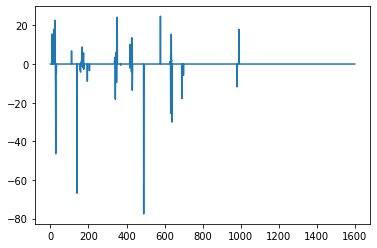

In [24]:
logreg_basalt = LogisticRegression(
    penalty="l1", solver="liblinear", C=20, random_state=RANDOM_SEED, max_iter = 100, verbose = 0
)
basalt_cv = cross_val_score(logreg_basalt, train_df, train_labels['basalt'], cv=skf,scoring=log_loss_scorer,)
print(basalt_cv.mean(),basalt_cv.std())
logreg_basalt.fit(train_df, train_labels['basalt'])
plt.plot(logreg_basalt.coef_.ravel(),)

In [25]:
imps = logreg_basalt.coef_
imps = pd.Series(imps.ravel())
imps = imps.where(imps != 0.0).dropna().sort_values(ascending=False).index
imps

Int64Index([578, 351,  24,  20, 991,   8, 635, 427, 429, 419, 990, 167,  19,
            111, 346, 174, 420, 633, 417, 339, 171, 424, 425, 169, 164, 637,
            636, 173, 337, 627, 989, 161, 162, 168, 163, 170, 370, 345, 428,
            166, 700, 172, 418, 638, 156, 175, 344, 205, 426, 158,  31, 634,
            699, 431, 194, 348, 347, 981,  27, 430, 691, 341, 491, 632, 639,
             28, 139, 490],
           dtype='int64')

In [ ]:
cb_clf = CatBoostClassifier(random_seed=RANDOM_SEED,verbose=999,eval_metric='Logloss')
cb_cvscore = logloss_cross_val(cb_clf,train_df.iloc[:,imps],train_labels,nsplits=3)
#  eta 0.008354

In [29]:
cb_cvscore

({'basalt': 0.18828937417066896,
  'carbonate': 0.12024706110486756,
  'chloride': 0.19061186090833537,
  'iron_oxide': 0.21487846278805361,
  'oxalate': 0.007846615665656557,
  'oxychlorine': 0.1699206932772332,
  'phyllosilicate': 0.27102300942991164,
  'silicate': 0.2095405184414981,
  'sulfate': 0.18617458310250823,
  'sulfide': 0.08407230957793475},
 0.1642604488466668)

### Catboost on different imp features for different targets 

In [83]:
imp_fts_dict = {}
for col in train_labels.columns:
    print("Target :",col)
    # Define stratified k-fold validation
    skf = StratifiedKFold(n_splits=10, random_state=RANDOM_SEED, shuffle=True)
    # Define log loss
    log_loss_scorer = make_scorer(log_loss,needs_proba=True)

    logreg_clf = LogisticRegression(penalty='l1',random_state=RANDOM_SEED,solver='liblinear',C=20)
    # check cv score for each target
    cv = cross_val_score(logreg_clf, train_df, train_labels[col], cv=skf,scoring=log_loss_scorer)
    print(cv)
    print("cv mean: ", cv.mean(), "cv std: ", cv.std())

    # collect non zero coeffs and store in imp_fts_dict
    logreg_clf.fit(train_df,train_labels[col])
    coefs = logreg_clf.coef_
    coefs = pd.Series(coefs.ravel())
    coefs = coefs.where(coefs != 0.0).dropna().sort_values(ascending=False).index
    imp_fts_dict[col] = coefs

Target : basalt
[0.28145629 0.20222666 0.36910234 0.22798772 0.21757914 0.29544072
 0.20097045 0.29409363 0.28466385 0.2953681 ]
cv mean:  0.26688889041325586 cv std:  0.050806806573264605
Target : carbonate
[0.19482698 0.41037536 0.19710714 0.17112708 0.2341675  0.64381442
 0.27073409 0.23091639 0.16539812 0.57081833]
cv mean:  0.30892854070010684 cv std:  0.16409558473395217
Target : chloride
[0.82290436 0.40821751 0.20691256 0.25194617 0.42625937 0.26595152
 0.15623535 0.23460981 0.46128416 0.27724636]
cv mean:  0.3511567163236281 cv std:  0.18398900294459541
Target : iron_oxide
[0.3648099  0.30963721 0.53064393 0.26110411 0.35804746 0.58574187
 0.39385339 0.47832248 0.44775951 0.25645293]
cv mean:  0.3986372799761864 cv std:  0.10538695097778113
Target : oxalate
[0.00043246 0.00117575 0.00161927 0.00470163 0.00081504 0.00119717
 0.0015451  0.00128765 0.00474454 0.00154794]
cv mean:  0.001906653191792414 cv std:  0.001448900402760595
Target : oxychlorine
[0.14260448 0.36150856 0.238

In [85]:
[len(imp_fts_dict[col]) for col in imp_fts_dict.keys()]

[68, 68, 70, 88, 11, 67, 82, 87, 74, 56]

In [87]:
for col in train_labels.columns:
    print("Target :",col)
    # Define stratified k-fold validation
    skf = StratifiedKFold(n_splits=10, random_state=RANDOM_SEED, shuffle=True)
    # Define log loss
    log_loss_scorer = make_scorer(log_loss,needs_proba=True)

    cb_clf = CatBoostClassifier(random_seed=RANDOM_SEED,verbose=False,eval_metric='Logloss')
    cv =  cross_val_score(cb_clf,train_df.iloc[:,imp_fts_dict[col]],train_labels[col],cv=skf,scoring=log_loss_scorer)
    print(cv)
    print("cv mean: ", cv.mean(), "cv std: ", cv.std())

Target : basalt


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

[0.15052713 0.15040269 0.3350209  0.12793076 0.15019269 0.20523295
 0.19710424 0.21792255 0.1862148  0.157915  ]
cv mean:  0.18784637155072298 cv std:  0.05626180235471972
Target : carbonate
[0.0680218  0.06599585 0.08776372 0.05272954 0.10583692 0.2447081
 0.13912305 0.08835207 0.13469994 0.14814648]
cv mean:  0.11353774590107993 cv std:  0.05375255042012596
Target : chloride
[0.17517862 0.16311785 0.12559912 0.19640469 0.28909492 0.2042061
 0.09385    0.12773808 0.21785161 0.17339423]
cv mean:  0.17664352081186974 cv std:  0.05247981458318296
Target : iron_oxide
[0.29324072 0.1998568  0.24477163 0.17379342 0.14257655 0.1473208
 0.24704426 0.28284446 0.19559076 0.1790757 ]
cv mean:  0.2106115093533889 cv std:  0.05085792083698198
Target : oxalate
[0.0009267  0.01764039 0.00162672 0.00706897 0.01897874 0.01061441
 0.00347737 0.0010289  0.00731543 0.00672949]
cv mean:  0.0075407113695742465 cv std:  0.00617127023663031
Target : oxychlorine
[0.10779347 0.1406152  0.13452193 0.22934622 0.

In [88]:
cvs = [0.18784637155072298,0.11353774590107993,0.17664352081186974 , 0.2106115093533889,0.007540711369574246,0.16727461773576674, 0.2555434721846475,0.2134356266280073,0.1714494762272890,0.07309272619430875]

In [90]:
np.array(cvs).mean()

0.15769757779566554

### What about nns on selected fts??

In [101]:
from tensorflow.keras import layers,models,metrics,callbacks,losses
from tensorflow.keras.activations import relu,sigmoid,swish,tanh,selu
from tensorflow.keras.optimizers import SGD,Adam,RMSprop
import tensorflow as tf

In [135]:
nn = models.Sequential()
nn.add(layers.Dense(1, input_shape=(train_df.iloc[:,imp_fts_dict['basalt']].shape[1],)))
nn.add(layers.Dense(800, activation=tanh))
nn.add(layers.Dense(400, activation=tanh))
nn.add(layers.Dense(10))
nn.add(layers.Lambda(lambda x: tf.keras.backend.clip(x, 0.0001, 0.9999)))

nn.compile(optimizer=Adam(learning_rate=0.001), loss=losses.CategoricalCrossentropy(), metrics=[metrics.CategoricalCrossentropy()])
print(nn.summary())

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 1)                 69        
_________________________________________________________________
dense_22 (Dense)             (None, 800)               1600      
_________________________________________________________________
dense_23 (Dense)             (None, 400)               320400    
_________________________________________________________________
dense_24 (Dense)             (None, 10)                4010      
_________________________________________________________________
lambda_10 (Lambda)           (None, 10)                0         
Total params: 326,079
Trainable params: 326,079
Non-trainable params: 0
_________________________________________________________________
None


In [136]:
callback = callbacks.EarlyStopping(monitor='val_loss', patience=10,restore_best_weights=True)

In [137]:
hist = nn.fit(train_df.iloc[:,imp_fts_dict['basalt']],train_labels,batch_size=612,epochs=150,validation_split=0.2,verbose=2,callbacks=[callback])

Epoch 1/150
1/1 - 1s - loss: 4.7251 - categorical_crossentropy: 4.7251 - val_loss: 6.0336 - val_categorical_crossentropy: 6.0336
Epoch 2/150
1/1 - 0s - loss: 6.6787 - categorical_crossentropy: 6.6787 - val_loss: 5.6509 - val_categorical_crossentropy: 5.6509
Epoch 3/150
1/1 - 0s - loss: 6.0273 - categorical_crossentropy: 6.0273 - val_loss: 5.6162 - val_categorical_crossentropy: 5.6162
Epoch 4/150
1/1 - 0s - loss: 5.9938 - categorical_crossentropy: 5.9938 - val_loss: 5.6236 - val_categorical_crossentropy: 5.6236
Epoch 5/150
1/1 - 0s - loss: 5.9916 - categorical_crossentropy: 5.9916 - val_loss: 5.5738 - val_categorical_crossentropy: 5.5738
Epoch 6/150
1/1 - 0s - loss: 5.9839 - categorical_crossentropy: 5.9839 - val_loss: 5.5476 - val_categorical_crossentropy: 5.5476
Epoch 7/150
1/1 - 0s - loss: 5.9522 - categorical_crossentropy: 5.9522 - val_loss: 5.5701 - val_categorical_crossentropy: 5.5701
Epoch 8/150
1/1 - 0s - loss: 5.9118 - categorical_crossentropy: 5.9118 - val_loss: 5.5108 - val_c

In [138]:
#  i think nns are absolutely a waste of time in this case

### Tried svm and logreg on train imp features

In [69]:
log_clf = LogisticRegression(random_state=RANDOM_SEED,verbose=0,penalty='l1',C=10,solver='liblinear')
log_cvscore = logloss_cross_val(log_clf,train_df.iloc[:,imps],train_labels,nsplits=5)
log_cvscore

({'basalt': 0.2683067334157245,
  'carbonate': 0.2824961882865381,
  'chloride': 0.2718993559266498,
  'iron_oxide': 0.3804138783590792,
  'oxalate': 0.003494474156954956,
  'oxychlorine': 0.3311883782764481,
  'phyllosilicate': 0.4645399716330522,
  'silicate': 0.3336856568198504,
  'sulfate': 0.328319778109153,
  'sulfide': 0.14695751219567454},
 0.2811301927179125)

In [73]:
svm_clf = SVC(random_state=RANDOM_SEED,verbose=1,probability=True)
svm_cvscore = logloss_cross_val(svm_clf,train_df.iloc[:,imps],train_labels,nsplits=3)
svm_cvscore

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

({'basalt': 0.2602430128289928,
  'carbonate': 0.18745751504389904,
  'chloride': 0.2869690909407553,
  'iron_oxide': 0.352568430674568,
  'oxalate': 0.012864080811357781,
  'oxychlorine': 0.25436904080238104,
  'phyllosilicate': 0.37366108764461786,
  'silicate': 0.2983867983800075,
  'sulfate': 0.27253603759571926,
  'sulfide': 0.10621789869385134},
 0.24052729934161493)

### Catboost on l1_tot_abund_imp_fts 
- upsampled cv loss is 0.12
- without upsampling cv loss is 0.19

In [7]:
tot_abund_imp_fts = load('l1_tot_abund_imp_fts_dict.joblib')
tot_abund_imp_fts['phyllosilicate']

Int64Index([55, 69, 30, 72, 39,  1, 14, 42, 34, 17, 31,  2, 13, 43, 29, 27, 99,
            18, 35, 16, 15,  4, 26, 40,  0, 47, 38,  3, 33, 19],
           dtype='int64')

In [18]:
logreg_clf = LogisticRegression(random_state=RANDOM_SEED,verbose=0,penalty='l1',C=10,solver='liblinear')
logreg_cvscore = logloss_cross_val(logreg_clf,train_df,train_labels,nsplits=10)

In [19]:
logreg_cvscore

({'basalt': 0.2908690428327613,
  'carbonate': 0.3066242555497567,
  'chloride': 0.3391700401132475,
  'iron_oxide': 0.37640322140497917,
  'oxalate': 0.004054584453948384,
  'oxychlorine': 0.2866645348619691,
  'phyllosilicate': 0.4154358926880845,
  'silicate': 0.37181695938703097,
  'sulfate': 0.409961917558196,
  'sulfide': 0.18903867440456762},
 0.29900391232545415)

In [20]:
tot_abund_imp_fts_dict_mixed = {}
cv_list = []
for col in train_labels.columns:
    print("Target :",col)
    # Define stratified k-fold validation
    skf = StratifiedKFold(n_splits=10, random_state=RANDOM_SEED, shuffle=True)
    # Define log loss
    log_loss_scorer = make_scorer(log_loss,needs_proba=True)

    logreg_clf = LogisticRegression(penalty='l1',random_state=RANDOM_SEED,solver='liblinear',C=10)
    # check cv score for each target
    cv = cross_val_score(logreg_clf, train_df, train_labels[col], cv=skf,scoring=log_loss_scorer)
    print(cv)
    print("cv mean: ", cv.mean(), "cv std: ", cv.std())
    cv_list.append(cv.mean())

    # collect non zero coeffs and store in tot_abund_imp_fts_dict_mixed
    logreg_clf.fit(train_df,train_labels[col])
    coefs = logreg_clf.coef_
    coefs = pd.Series(coefs.ravel())
    coefs = coefs.where(coefs != 0.0).dropna().sort_values(ascending=False).index
    tot_abund_imp_fts_dict_mixed[col] = coefs

Target : basalt
[0.24061223 0.18193615 0.39784157 0.20591818 0.48632038 0.3646586
 0.2522026  0.25311382 0.31064896 0.21543795]
cv mean:  0.2908690428327613 cv std:  0.09257411236049491
Target : carbonate
[0.20083117 0.31059588 0.17571363 0.16892331 0.24455976 0.80774629
 0.21758708 0.24215335 0.26802696 0.43010512]
cv mean:  0.30662425554975664 cv std:  0.18196257336726052
Target : chloride
[0.84596205 0.36553713 0.15532271 0.27963954 0.41581153 0.28230725
 0.17545554 0.2479177  0.36310199 0.26064496]
cv mean:  0.3391700401132475 cv std:  0.1859711640548894
Target : iron_oxide
[0.38733524 0.37812592 0.40641022 0.2566563  0.37429869 0.53253654
 0.37542888 0.42459025 0.40248556 0.22616461]
cv mean:  0.3764032214049792 cv std:  0.0808202524475268
Target : oxalate
[0.00123825 0.000865   0.00246681 0.00403684 0.00053017 0.01267582
 0.00204895 0.0017305  0.01077965 0.00417386]
cv mean:  0.004054584453948381 cv std:  0.004025401286313474
Target : oxychlorine
[0.1832309  0.35475715 0.22729311

In [23]:
cv_list = [0.2908690428327613 ,0.30662425554975664 ,0.3391700401132475 ,0.3764032214049792 ,0.004054584453948381,0.2866645348619691 ,0.41543589268808445,0.37181695938703097,0.409961917558196 ,0.18903867440456762    ]
np.array(cv_list).mean()

0.29900391232545415

In [22]:
tot_abund_imp_fts_dict_mixed.keys()

dict_keys(['basalt', 'carbonate', 'chloride', 'iron_oxide', 'oxalate', 'oxychlorine', 'phyllosilicate', 'silicate', 'sulfate', 'sulfide'])

In [24]:
skf = StratifiedKFold(n_splits=10, random_state=RANDOM_SEED, shuffle=True)
cv = []
for col in train_labels.columns:
    print("Target :",col)
    # sampler = SMOTETomek(random_state=RANDOM_SEED)
    # sampled_train_col = sampler.fit_resample(tot_abund_df.iloc[:,tot_abund_imp_fts_dict[col]], train_labels[col])
    cb_clf = CatBoostClassifier(random_state=RANDOM_SEED,verbose=False,eval_metric='Logloss')
    cb_logloss = cross_val_score(cb_clf,train_df.iloc[:,tot_abund_imp_fts_dict_mixed[col]],train_labels[col],scoring=log_loss_scorer,cv=skf)
    print("catboost model log-loss:")
    print(cb_logloss)
    print("mean logloss --> ",cb_logloss.mean()," loss std --> ",cb_logloss.std())
    print("------------------------------------------------------------------------")
    cv.append(cb_logloss.mean())
print(cv)
print(np.array(cv).mean())

Target : basalt
catboost model log-loss:
[0.14591509 0.16290024 0.30852966 0.12917836 0.16941933 0.19605544
 0.19931107 0.22922979 0.19879662 0.159036  ]
mean logloss -->  0.1898371595962705  loss std -->  0.0485265075804131
------------------------------------------------------------------------
Target : carbonate
catboost model log-loss:
[0.0611044  0.06055104 0.10049762 0.05437403 0.10405143 0.22489677
 0.1518459  0.08090222 0.11978311 0.15071867]
mean logloss -->  0.11087251729595364  loss std -->  0.050597473146514665
------------------------------------------------------------------------
Target : chloride
catboost model log-loss:
[0.16920064 0.17976555 0.12714085 0.19307841 0.26745554 0.19358702
 0.0953205  0.12497579 0.25133394 0.17848081]
mean logloss -->  0.17803390585811468  loss std -->  0.051152087599242536
------------------------------------------------------------------------
Target : iron_oxide
catboost model log-loss:
[0.2911899  0.20040303 0.23526644 0.14811042 0.138

In [27]:
np.array(cv).mean()

0.15614295665085562

# Modelling

In [ ]:
# coefs == imp_fts_index 

In [9]:
train_df['tot_abund'] = train_df.sum(axis=1)   # do for test
train_df.head()

m/z               0                                                 \
temp_bin  (-100, 0]  (0, 100] (100, 200] (1000, 1100] (1100, 1200]   
sample_id                                                            
S0000           0.0  0.004085   0.004641     0.000000          0.0   
S0001           0.0  0.000000   0.000000     0.000000          0.0   
S0002           0.0  0.002270   0.002495     0.000000          0.0   
S0003           0.0  0.001336   0.002464     0.000306          0.0   
S0004           0.0  0.005993   0.012429     0.000593          0.0   

m/z                                                                     ...  \
temp_bin  (1200, 1300] (1300, 1400] (1400, 1500] (200, 300] (300, 400]  ...   
sample_id                                                               ...   
S0000              0.0          0.0          0.0   0.001394   0.000188  ...   
S0001              0.0          0.0          0.0   0.000000   0.000000  ...   
S0002              0.0          0.0          0.0   0.001688   0.000636  ...   
S0003              0.0          0.0          0.0   0.001099   0.000992  ...   
S0004              0.0          0.0          0.0   0.009380   0.005099  ...   

m/z                 99                                                 \
temp_bin  (1400, 1500]    (200, 300] (300, 400] (400, 500] (500, 600]   
sample_id                                                               
S0000              0.0  2.898509e-06   0.000003   0.000000   0.000000   
S0001              0.0  0.000000e+00   0.000000   0.000000   0.000000   
S0002              0.0  9.257968e-07   0.000001   0.000001   0.000001   
S0003              0.0  4.379099e-06   0.000006   0.000005   0.000005   
S0004              0.0  3.904920e-06   0.000004   0.000004   0.000005   

m/z                                                       tot_abund  
temp_bin     (600, 700] (700, 800] (800, 900] (900, 1000]            
sample_id                                                            
S0000      0.000000e+00   0.000000   0.000000    0.000000  3.014152  
S0001      0.000000e+00   0.000000   0.000000    0.000000  1.760583  
S0002      9.397170e-07   0.000001   0.000001    0.000001  4.175911  
S0003      4.693477e-06   0.000004   0.000004    0.000004  4.712937  
S0004      3.174421e-06   0.000004   0.000004    0.000003  4.288637  

[5 rows x 1601 columns]

In [10]:
test_df['tot_abund'] = test_df.sum(axis=1)   # do for test
test_df.head()

m/z               0                                                 \
temp_bin  (-100, 0]  (0, 100] (100, 200] (1000, 1100] (1100, 1200]   
sample_id                                                            
S0766           0.0  0.410100   0.593334     0.206508     0.000000   
S0767           0.0  0.058563   0.073878     0.088571     0.097939   
S0768           0.0  0.029256   0.040753     0.013179     0.000000   
S0769           0.0  0.000261   0.000842     0.000000     0.000000   
S0770           0.0  0.003460   0.003929     0.000467     0.000000   

m/z                                                                     ...  \
temp_bin  (1200, 1300] (1300, 1400] (1400, 1500] (200, 300] (300, 400]  ...   
sample_id                                                               ...   
S0766         0.000000          0.0          0.0   0.606578   0.678006  ...   
S0767         0.063057          0.0          0.0   0.081069   0.083869  ...   
S0768         0.000000          0.0          0.0   0.037022   0.041347  ...   
S0769         0.000000          0.0          0.0   0.001313   0.001544  ...   
S0770         0.000000          0.0          0.0   0.003286   0.002893  ...   

m/z                 99                                                         \
temp_bin  (1400, 1500] (200, 300] (300, 400] (400, 500] (500, 600] (600, 700]   
sample_id                                                                       
S0766              0.0   0.001801   0.001626   0.001498   0.001380   0.001495   
S0767              0.0   0.000153   0.000187   0.000173   0.000150   0.000183   
S0768              0.0   0.000205   0.000122   0.000152   0.000161   0.000158   
S0769              0.0   0.000010   0.000010   0.000008   0.000009   0.000012   
S0770              0.0   0.000002   0.000002   0.000002   0.000002   0.000001   

m/z                                          tot_abund  
temp_bin  (700, 800] (800, 900] (900, 1000]             
sample_id                                               
S0766       0.001755   0.001762    0.001607  49.135066  
S0767       0.000162   0.000146    0.000133  16.354304  
S0768       0.000182   0.000248    0.000144  14.889806  
S0769       0.000011   0.000012    0.000000   5.083412  
S0770       0.000003   0.000002    0.000002   2.462505  

[5 rows x 1601 columns]

In [11]:
def get_mz(mz):
    cols_list = []
    for col in train_df.columns:
        if col[0] == str(mz):
            cols_list.append(col)
    return cols_list

In [12]:
for mz in tqdm(range(0,100)):
    train_df[f"tot_abund_{mz}"] = train_df[get_mz(mz)].sum(axis=1)
for mz in tqdm(range(0,100)):
    test_df[f"tot_abund_{mz}"] = test_df[get_mz(mz)].sum(axis=1)

100%|██████████| 100/100 [00:01<00:00, 54.70it/s]


In [15]:
test_df

m/z               0                                                 \
temp_bin  (-100, 0]  (0, 100] (100, 200] (1000, 1100] (1100, 1200]   
sample_id                                                            
S0766           0.0  0.410100   0.593334     0.206508     0.000000   
S0767           0.0  0.058563   0.073878     0.088571     0.097939   
S0768           0.0  0.029256   0.040753     0.013179     0.000000   
S0769           0.0  0.000261   0.000842     0.000000     0.000000   
S0770           0.0  0.003460   0.003929     0.000467     0.000000   
...             ...       ...        ...          ...          ...   
S1565           0.0  0.000000   0.000000     0.000000     0.000000   
S1566           0.0  0.000049   0.000000     0.000000     0.000000   
S1567           0.0  0.000000   0.000000     0.000000     0.000000   
S1568           0.0  0.000000   0.000000     0.000000     0.000000   
S1569           0.0  0.000000   0.000000     0.000000     0.000000   

m/z                                                                     ...  \
temp_bin  (1200, 1300] (1300, 1400] (1400, 1500] (200, 300] (300, 400]  ...   
sample_id                                                               ...   
S0766         0.000000          0.0          0.0   0.606578   0.678006  ...   
S0767         0.063057          0.0          0.0   0.081069   0.083869  ...   
S0768         0.000000          0.0          0.0   0.037022   0.041347  ...   
S0769         0.000000          0.0          0.0   0.001313   0.001544  ...   
S0770         0.000000          0.0          0.0   0.003286   0.002893  ...   
...                ...          ...          ...        ...        ...  ...   
S1565         0.000000          0.0          0.0   0.000000   0.000000  ...   
S1566         0.000000          0.0          0.0   0.000000   0.000000  ...   
S1567         0.000000          0.0          0.0   0.000000   0.000000  ...   
S1568         0.000000          0.0          0.0   0.000000   0.000000  ...   
S1569         0.000000          0.0          0.0   0.000000   0.000000  ...   

m/z       tot_abund_90 tot_abund_91 tot_abund_92 tot_abund_93 tot_abund_94  \
temp_bin                                                                     
sample_id                                                                    
S0766         0.017303     0.014516     0.016294     0.016206     0.016218   
S0767         0.001840     0.002187     0.002017     0.001949     0.001945   
S0768         0.001564     0.001702     0.001728     0.001620     0.001876   
S0769         0.000112     0.000109     0.000088     0.000108     0.000098   
S0770         0.000022     0.000025     0.000022     0.000022     0.000021   
...                ...          ...          ...          ...          ...   
S1565         0.000000     0.086313     0.000000     0.000000     0.000000   
S1566         0.000492     0.002167     0.001428     0.000886     0.001625   
S1567         0.001261     0.009706     0.004162     0.003262     0.004903   
S1568         0.002863     0.012187     0.007543     0.006600     0.008276   
S1569         0.000000     0.117340     0.000000     0.000000     0.069365   

m/z       tot_abund_95 tot_abund_96 tot_abund_97 tot_abund_98 tot_abund_99  
temp_bin                                                                    
sample_id                                                                   
S0766         0.016532     0.014431     0.012585     0.014749     0.016790  
S0767         0.002117     0.002137     0.002009     0.002131     0.002034  
S0768         0.001640     0.001640     0.001637     0.001555     0.001742  
S0769         0.000098     0.000116     0.000125     0.000098     0.000093  
S0770         0.000022     0.000020     0.000020     0.000022     0.000022  
...                ...          ...          ...          ...          ...  
S1565         0.000000     0.000000     0.000000     0.000000     0.000000  
S1566         0.001132     0.001428     0.001280 

In [95]:
# training with imp_fts_index
def train_and_predict(col):
    train_imp_fts = train_df.iloc[:,imp_fts_dict[col]]
    test_imp_fts = test_df.iloc[:,imp_fts_dict[col]]
    clf = CatBoostClassifier(random_state=RANDOM_SEED,verbose=False,eval_metric='Logloss',task_type='CPU')
    clf.fit(train_imp_fts,train_labels[col])
    preds = clf.predict_proba(test_imp_fts)
    preds = preds[:,1]
    submission_template_df[col] = preds
    return clf, preds

In [ ]:
results = {}
for col in tqdm(train_labels.columns):
    results[col] = train_and_predict(col)
print('all good :)')

In [98]:
submission_template_df.head()

,sample_id,basalt,carbonate,chloride,iron_oxide,oxalate,oxychlorine,phyllosilicate,silicate,sulfate,sulfide
0,S0766,0.008515,0.004105,0.017981,0.009874,0.001412,0.008454,0.019390,0.271978,0.005496,0.002052
1,S0767,0.077800,0.035944,0.004325,0.036534,0.000102,0.034601,0.045297,0.609227,0.091435,0.001141
2,S0768,0.484653,0.146311,0.002644,0.081566,0.002529,0.017212,0.394838,0.623719,0.043436,0.000775
3,S0769,0.020934,0.012400,0.068250,0.019692,0.000095,0.879791,0.100869,0.010727,0.871765,0.002046
4,S0770,0.022837,0.010769,0.014176,0.226716,0.000148,0.980885,0.899091,0.009366,0.014347,0.000715


In [99]:
submission_template_df.describe()

,basalt,carbonate,chloride,iron_oxide,oxalate,oxychlorine,phyllosilicate,silicate,sulfate,sulfide
count,804.000000,804.000000,804.000000,804.000000,804.000000,804.000000,804.000000,804.000000,804.000000,804.000000
mean,0.078483,0.118999,0.097082,0.169565,0.035201,0.188936,0.296443,0.103878,0.162384,0.037270
std,0.181363,0.268019,0.199739,0.262904,0.174971,0.328374,0.350624,0.206015,0.293087,0.146485
min,0.002834,0.001488,0.001984,0.003239,0.000069,0.002775,0.002868,0.002762,0.001790,0.000368
25%,0.009633,0.006857,0.007400,0.017270,0.000134,0.010645,0.031280,0.010037,0.008597,0.000691
50%,0.019441,0.014295,0.017098,0.041274,0.000231,0.025661,0.099027,0.021206,0.018716,0.001284
75%,0.047220,0.040816,0.055102,0.159096,0.000868,0.094257,0.582143,0.064119,0.098102,0.004943
max,0.977683,0.982626,0.982037,0.984114,0.997590,0.997344,0.987424,0.975897,0.991398,0.986964


In [100]:
submission_template_df.to_csv('catboost_preds_on_test_imp_fts-2.csv',index=False)

In [ ]:
# clf.classes_

array([0, 1], dtype=int64)